Author: Saman Paidar Nia

In [1]:
# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import csv
import random
import math
#--------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm

In [2]:
class Similarity_func:
    def sigmoidal_normalize(self, X):
        X= (X - min(X)) / (max(X) - min(X))
        return X

In [3]:
class Cosine_Similarity(Similarity_func):
    def get_matrix(self, data):
        data = normalize(data, axis=0)
        m = squareform(pdist(data, 'cosine'))
        m = np.dot(LA.matrix_power(np.diag(np.sum(m, 0)), -1), m)
        m = np.apply_along_axis(self.sigmoidal_normalize, 1, m)
        np.fill_diagonal(m, 0.)
        return m

In [4]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [5]:
#  Using Scikit-Learn libraries to fetching the Newsgroups data set: http://scikit-learn.org
def read_NewsGroup_data(similarity):
    from sklearn.datasets import fetch_20newsgroups
    from sklearn.decomposition import TruncatedSVD
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import HashingVectorizer
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import Normalizer
    from sklearn import metrics
    import logging
    from optparse import OptionParser
    import sys    
    # Display progress logs on stdout
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    # parse commandline arguments
    op = OptionParser()
    op.add_option("--lsa",
                  dest="n_components", type="int",
                  help="Preprocess documents with latent semantic analysis.")
    op.add_option("--no-minibatch",
                  action="store_false", dest="minibatch", default=True,
                  help="Use ordinary k-means algorithm (in batch mode).")
    op.add_option("--no-idf",
                  action="store_false", dest="use_idf", default=True,
                  help="Disable Inverse Document Frequency feature weighting.")
    op.add_option("--use-hashing",
                  action="store_true", default=False,
                  help="Use a hashing feature vectorizer")
    op.add_option("--n-features", type=int, default=10000,
                  help="Maximum number of features (dimensions)"
                       " to extract from text.")
    op.add_option("--verbose",
                  action="store_true", dest="verbose", default=False,
                  help="Print progress reports inside k-means algorithm.")
    def is_interactive():
        return not hasattr(sys.modules['__main__'], '__file__')
    # work-around for Jupyter notebook and IPython console
    argv = [] if is_interactive() else sys.argv[1:]
    (opts, args) = op.parse_args(argv)
    if len(args) > 0:
        op.error("this script takes no arguments.")
        sys.exit(1)
    # Display progress logs on stdout
   #############################################################################
    # Load some categories from the training set
    categories_9NG = ['talk.politics.mideast', 'talk.politics.misc', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware',
                      'sci.electronics', 'sci.crypt', 'sci.med', 'sci.space', 'misc.forsale']
    # Uncomment the following to do the analysis on all the categories
    # categories = None
    dataset = fetch_20newsgroups(subset='all', categories=categories_9NG,
                                 shuffle=True, random_state=42)
    labels = dataset.target[:1800]
    true_k = np.unique(labels).shape[0]
    if opts.use_hashing:
        if opts.use_idf:
            # Perform an IDF normalization on the output of HashingVectorizer
            hasher = HashingVectorizer(n_features=opts.n_features,
                                       stop_words='english', alternate_sign=False,norm=None, binary=False)
            vectorizer = make_pipeline(hasher, TfidfTransformer())
        else:
            vectorizer = HashingVectorizer(n_features=opts.n_features,stop_words='english',
                                           alternate_sign=False, norm='l2',binary=False)
    else:
        vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,min_df=2,
                                     stop_words='english',use_idf=opts.use_idf)
    X = vectorizer.fit_transform(dataset.data[:1800])
    if opts.n_components:    
        # Vectorizer results are normalized, which makes KMeans behave as
        # spherical k-means for better results. Since LSA/SVD results are
        # not normalized, we have to redo the normalization.
        svd = TruncatedSVD(opts.n_components)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
        X = lsa.fit_transform(X)
        explained_variance = svd.explained_variance_ratio_.sum()
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

In [6]:
# Call Cosine_Similarity as similarity dataset.
data_set_train = read_NewsGroup_data(Cosine_Similarity())

In [7]:
def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [8]:
n_code = '32' #-----------------------The number of output dimension value or embedding data codes.
n_input = data_set_train.data_size #------------------------------------------Number of input data.
n_hidden_1 = 1024 #-------------------------------------------------The autoencoder hidden layer 1.
n_hidden_2 = 512 #--------------------------------------------------The autoencoder hidden layer 2.
n_hidden_3 = 256 #--------------------------------------------------The autoencoder hidden layer 3.
n_hidden_4 = 128 #--------------------------------------------------The autoencoder hidden layer 4.
n_node_layers = (n_input+n_hidden_1+n_hidden_2+n_hidden_3+n_hidden_4+int(n_code))#---Collect nodes.

In [9]:
def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3], phase_train)
        with tf.variable_scope("hidden_4"):
            hidden_4 = layer(hidden_3, [n_hidden_3, n_hidden_4], [n_hidden_4], phase_train)
        with tf.variable_scope("code"):
            code = layer(hidden_4, [n_hidden_4, n_code], [n_code], phase_train)
    return code

In [10]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_hidden_4], [n_hidden_4], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_4, n_hidden_3], [n_hidden_3], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_3, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_4"):
            hidden_4 = layer(hidden_3, [n_hidden_2, n_hidden_1], [n_hidden_1], phase_train)
        with tf.variable_scope("output"):
            output = layer(hidden_4, [n_hidden_1, n_input], [n_input], phase_train)
    return output

In [11]:
def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [12]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0 / weight_shape[0]) ** 0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [13]:
def loss(output, x):
    with tf.variable_scope("training"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        train_summary_op = tf.summary.scalar("train_cost", train_loss)
        return train_loss

In [14]:
def training(cost, learning_rate, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [15]:
def evaluate(output, x):
    with tf.variable_scope("validation"):
        val_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        val_summary_op = tf.summary.scalar("val_cost", val_loss)
        return val_loss

In [16]:
# Parameters
n_layers = 6 #------------------------------- Number of Neural Networks Layers.
learning_rate = 0.0009 #--------------------- The learning rate, it should be a floating point value.
n_batch = math.ceil(n_input/100) #----------- Number of selection data in per step.
n_backpro =  math.ceil(n_input/n_batch) #---- Number of Backpro in per epoc
n_epoch = math.ceil(n_input/10) #------------ The time priod of train.
n_cluster = 9 #------------------------------ Number of clusters.
n_diplay = (n_epoch/10) #-------------------- Number of runnig the K-Means and NMI.
results=[] #--------------------------------- A list to keep all NMI scores.
loss_cost=[] #------------------------------- A list to keep all training evaluations.
steps=[] #----------------------------------- A list to keep all steps.

In [17]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_model"):                
        x = tf.placeholder("float", [None, n_input])   
        phase_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        cost = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, global_step)
        eval_optimizer = evaluate(output, x)
        summary_op = tf.summary.merge_all()
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [18]:
# Training cycle
for epoch in tqdm(range(1, n_epoch+1)):
    average_cost = 0.
    # Fit training with Backpropagation using batch data.
    for i in range(n_backpro):
        minibatch, _ = data_set_train.next_batch(n_batch)
        _, new_cost = sess.run([train_optimizer, cost], feed_dict={x: minibatch,
                                                                   phase_train: True})
        average_cost += new_cost/n_backpro
        ############## End of the Backpropagation with Random Walk ##############
    miniData, _ = data_set_train.next_batch(data_set_train.data_size)
    val_loss = sess.run(eval_optimizer, feed_dict={x: miniData,
                                                   phase_train: True})    
    ae_codes = sess.run(code, feed_dict={x: data_set_train.whole_dataset()[0],
                                         phase_train: True})
            ############## End of the Optimization ##############
    # Save the results after per 10 epochs.
    if epoch % n_diplay == 0 or epoch == n_epoch:
        # Running K-Means on Embedding Data.
        idx = k_means_(ae_codes, n_cluster)
        ae_nmi = normalized_mutual_info_score(data_set_train.whole_dataset()[1], idx)
        results.append(ae_nmi)    
        steps.append(epoch)
        loss_cost.append(average_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi,new_cost, epoch))

  9%|███████▋                                                                         | 17/180 [04:13<40:32, 14.92s/it]

NMI Score for AE is: 0.21 and new cost is: 78.16 in 18 step. 


 19%|███████████████▊                                                                 | 35/180 [08:44<36:11, 14.98s/it]

NMI Score for AE is: 0.22 and new cost is: 21.56 in 36 step. 


 29%|███████████████████████▊                                                         | 53/180 [13:15<31:45, 15.00s/it]

NMI Score for AE is: 0.23 and new cost is: 8.24 in 54 step. 


 39%|███████████████████████████████▉                                                 | 71/180 [17:42<27:10, 14.96s/it]

NMI Score for AE is: 0.25 and new cost is: 3.70 in 72 step. 


 49%|████████████████████████████████████████                                         | 89/180 [22:10<22:40, 14.95s/it]

NMI Score for AE is: 0.29 and new cost is: 2.26 in 90 step. 


 59%|███████████████████████████████████████████████▌                                | 107/180 [26:37<18:09, 14.93s/it]

NMI Score for AE is: 0.35 and new cost is: 1.81 in 108 step. 


 69%|███████████████████████████████████████████████████████▌                        | 125/180 [31:04<13:40, 14.92s/it]

NMI Score for AE is: 0.40 and new cost is: 1.41 in 126 step. 


 79%|███████████████████████████████████████████████████████████████▌                | 143/180 [35:35<09:12, 14.93s/it]

NMI Score for AE is: 0.49 and new cost is: 1.32 in 144 step. 


 89%|███████████████████████████████████████████████████████████████████████▌        | 161/180 [40:05<04:43, 14.94s/it]

NMI Score for AE is: 0.52 and new cost is: 1.22 in 162 step. 


 99%|███████████████████████████████████████████████████████████████████████████████▌| 179/180 [44:33<00:14, 14.93s/it]

NMI Score for AE is: 0.53 and new cost is: 1.15 in 180 step. 


100%|████████████████████████████████████████████████████████████████████████████████| 180/180 [44:48<00:00, 14.94s/it]


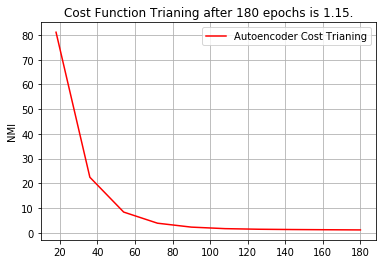

In [19]:
plt.errorbar(steps, loss_cost, label='Autoencoder Cost Trianing', color='r')
plt.ylabel('NMI')
plt.grid()
plt.title(('Cost Function Trianing after {:d} epochs is {:0.2f}.').format(n_epoch,new_cost))
plt.legend(loc='best')
plt.show()

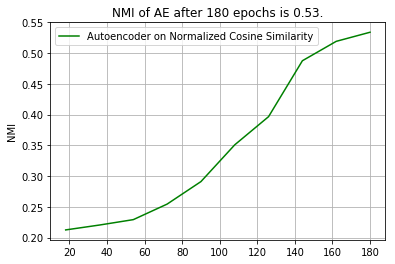

In [20]:
plt.errorbar(steps, results, label='Autoencoder on Normalized Cosine Similarity', color='g')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of AE after {:d} epochs is {:0.2f}.').format(n_epoch,ae_nmi))
plt.legend(loc='best')
plt.show()